misc notes:

clearing gpu memory: `for i in $(sudo lsof /dev/nvidia0 | grep python | awk '{print $2}' | sort -u); do sudo kill -9 $i; done`
https://github.com/tensorflow/tensorflow/issues/36465

In [1]:
from ptycho import params
h = w = N = params.cfg['N'] = 64
# offset between neighboring scan points, in pixels
offset = params.cfg['offset'] = 8#4
gridsize = params.cfg['gridsize'] = 2

nepochs=20
batch_size = params.cfg['batch_size'] = 16

In [2]:
%matplotlib inline

import os
from ptycho import tf_helper as hh
from ptycho import fourier as f
from ptycho import datasets
from ptycho import physics
#from ptycho.params import params

from sklearn.utils import shuffle

from importlib import reload
import os

import tensorflow as tf

import tensorflow_addons as tfa

import importlib
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
# from tqdm.notebook import tqdm as tqdm

from tensorflow.keras.layers import Layer
from math import pi
from tensorflow.keras import backend as K

matplotlib.rcParams['font.size'] = 12

2022-11-21 23:50:53.221233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 23:50:53.305134: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 23:50:53.627660: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2022-11-21 23:50:53.627702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

Instructions for updating:
ksizes is deprecated, use sizes instead


2022-11-21 23:50:54.591782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 23:50:54.592678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 23:50:54.592860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 23:50:54.592979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
!nvidia-smi

/bin/bash: /home/ollie/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Mon Nov 21 23:50:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   53C    P2    94W / 420W |  11475MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------------------

### Some training and probe parameters

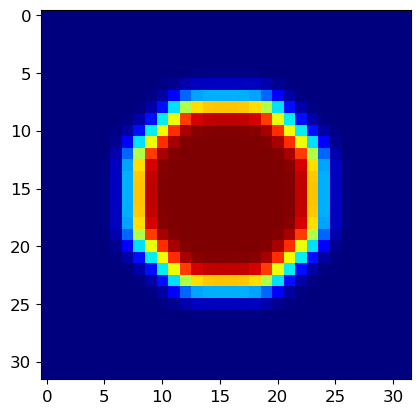

In [4]:
#filt = f.lowpass_g(.55, np.ones(N), sym = True)
# filt = f.lowpass_g(.7, np.ones(N), sym = True)
filt = f.lowpass_g(.9, np.ones(N), sym = True)

# TODO assert symmetry
probe = f.gf(((np.einsum('i,j->ij', filt, filt)) > .5).astype(float), 1) + 1e-9
probe_small = probe[16:-16, 16:-16]
tprobe = (tf.convert_to_tensor(probe, tf.float32)[..., None])
params.cfg['probe'] = tprobe
tprobe_small = (tf.convert_to_tensor(probe_small, tf.float32)[..., None])

# if (not os.path.isdir(path+wt_path)):
#     os.mkdir(wt_path)

plt.imshow(tprobe_small, cmap = 'jet')

In [5]:
# tf.config.experimental_run_functions_eagerly(
#     False
# )

### Simulate ptychography data

In [6]:
bigoffset = (gridsize - 1) * offset + N // 2
big_gridsize = 10
bigN = params.params()['bigN']
size = bigoffset * (big_gridsize - 1) + bigN

bigoffset = params.cfg['bigoffset'] = ((gridsize - 1) * offset + N // 2) // 2

In [7]:
np.random.seed(1)

X_train, Y_I_train, Y_phi_train, intensity_scale, _Y_I_train_full, _  = datasets.mk_simdata(9, size, probe)
# X_train, Y_I_train, Y_phi_train, intensity_scale, _Y_I_train_full, _  = datasets.mk_simdata(1, size, probe)
params.cfg['intensity_scale'] = intensity_scale

np.random.seed(2)
X_test, Y_I_test, Y_phi_test, _, _Y_I_test_full, norm_Y_I_test = datasets.mk_simdata(3, size, probe, intensity_scale)
# X_test, Y_I_test, Y_phi_test, _, _Y_I_test_full, norm_Y_I_test = datasets.mk_simdata(1, size, probe, intensity_scale)

# TODO shuffle should be after flatten
X_train, Y_I_train, Y_phi_train = shuffle(X_train.numpy(), Y_I_train.numpy(), Y_phi_train.numpy(), random_state=0)

(Y_I_test).shape, Y_I_train.shape


Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


(TensorShape([4107, 64, 64, 4]), (12321, 64, 64, 4))

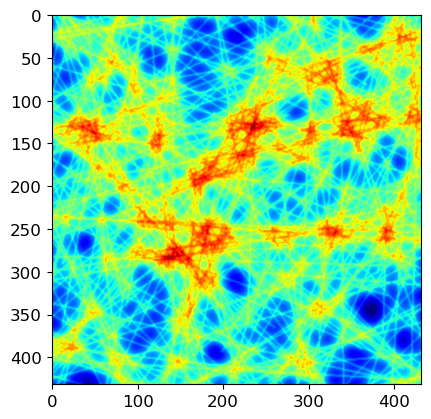

In [8]:
plt.imshow(_Y_I_train_full[0], cmap = 'jet')

In [9]:
print('intensity scale:', intensity_scale, '\n',
      'max photon count:', (np.max(Y_I_train, axis = (1, 2, 3)).mean() * intensity_scale)**2, '\n',
      'shapes:', (Y_phi_test).shape, (Y_I_test).shape, Y_I_train.shape)

intensity scale: 3515.079074671993 
 max photon count: 8598922.719591636 
 shapes: (4107, 64, 64, 4) (4107, 64, 64, 4) (12321, 64, 64, 4)


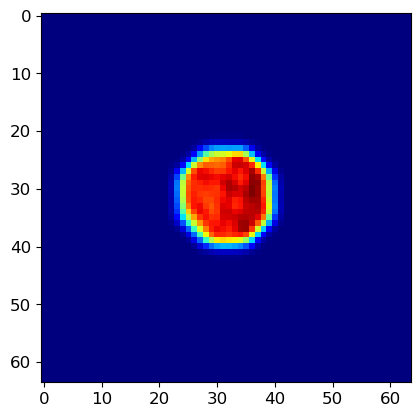

In [10]:
plt.imshow(Y_I_train[0, :, :, 0], cmap = 'jet')

### Norm conservation consistency check:

In [11]:
print(np.linalg.norm(X_train[0]) /  np.linalg.norm(Y_I_train[0]))

def normed_ff_np(arr):
    return (f.fftshift(np.absolute(f.fft2(np.array(arr)))) / np.sqrt(h * w))

0.9999993


### Inversion symmetry check:

In [12]:
assert np.isclose(normed_ff_np(Y_I_train[0, :, :, 0]),
            tf.math.conj(normed_ff_np(Y_I_train[0, ::-1, ::-1, 0])), atol = 1e-6).all()

#normed_ff_np(Y_I_train[0, :, :, 0]).sum() / normed_ff_np(Y_I_train[0, :, :, 0]).sum()

### np / tf consistency check:

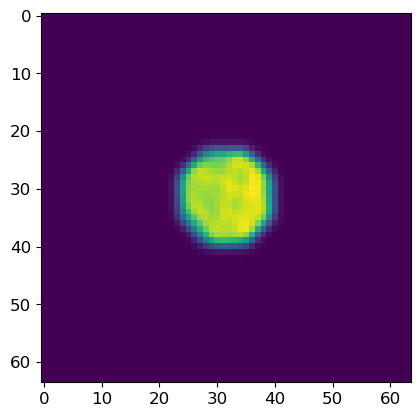

In [13]:
plt.imshow(Y_I_train[0, :, :, 0])

### Number of photons consistency check

In [14]:
np.log10(np.sum((X_train[:, :, :] * intensity_scale)**2, axis = (1, 2))).mean()

8.968989

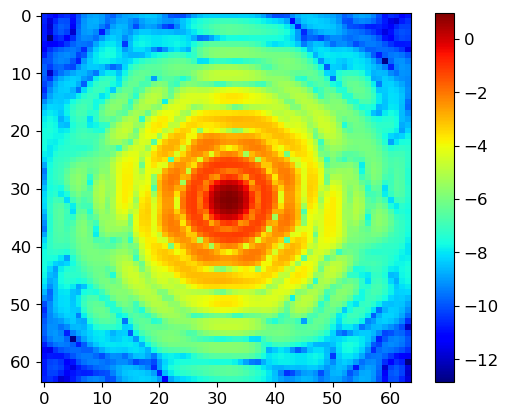

In [15]:
i = 1

plt.imshow(np.log(normed_ff_np
                  (np.array(hh.combine_complex(Y_I_train, Y_phi_train))[0, :, :, 0])), cmap = 'jet')
plt.colorbar()

/tmp/ipykernel_820849/2642748978.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_train[0, :, :, 0]), cmap = 'jet')


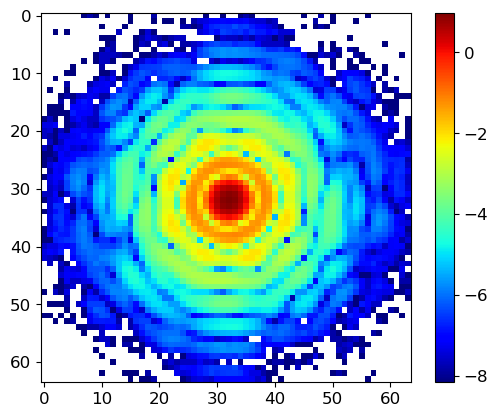

In [16]:
plt.imshow(np.log(X_train[0, :, :, 0]), cmap = 'jet')
plt.colorbar()

In [17]:
tmp = X_train.mean(axis = (0, 3))
probe_fif = np.absolute(f.fftshift(f.ifft2(f.ifftshift(tmp))))[N // 2, :]

# variance increments of a slice down the middle
d_second_moment = (probe_fif / probe_fif.sum()) * ((np.arange(N) - N // 2)**2)

probe_sigma_guess = np.sqrt(d_second_moment.sum())

from scipy import signal

centered_indices = np.arange(N) - N // 2 + .5
x, y = np.meshgrid(centered_indices, centered_indices)
d = np.sqrt(x*x+y*y)
mu = 0.
probe_mask = (d < N // 4)
probe_guess = np.exp(-( (d-mu)**2 / ( 2.0 * probe_sigma_guess**2 ) ) )
probe_guess *= probe_mask

In [18]:
# params.cfg['probe'] = tf.Variable(
#     initial_value = tf.convert_to_tensor(probe_guess, tf.float32)[..., None],
#     trainable = True)

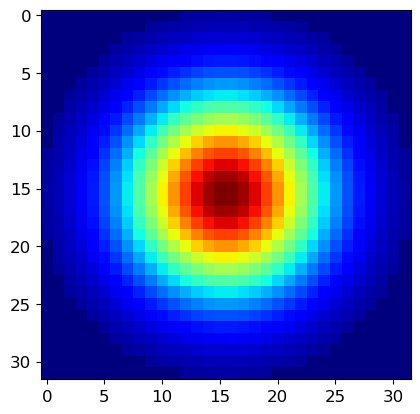

In [19]:
plt.imshow((probe_guess[N // 4: -N // 4, N // 4: -N // 4]), cmap = 'jet')

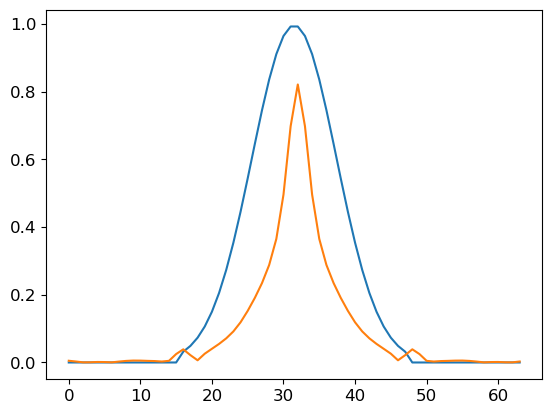

In [20]:
plt.plot(probe_guess[N // 2])
plt.plot(probe_fif * 30)
# plt.plot(g[N // 2])
# plt.plot(g[N // 2 - 1])

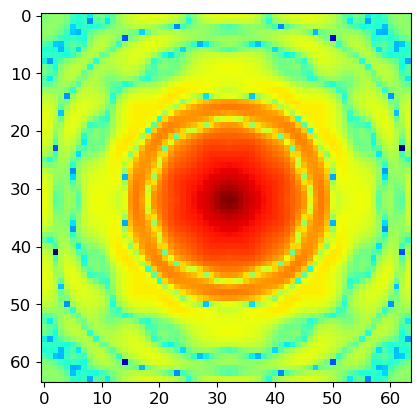

In [21]:
plt.imshow(
    np.log(np.absolute(f.fftshift(f.ifft2(f.ifftshift(tmp))))), cmap = 'jet'
)

## Define the network structure

In [22]:
from ptycho import params

In [23]:
from ptycho import model
# reload(hh)
# reload(model.hh)
# reload(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   2368        ['input[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

In [24]:
X_train.shape, X_test.shape

((12321, 64, 64, 4), TensorShape([4107, 64, 64, 4]))

In [41]:
reload(model.hh)
reload(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   2368        ['input[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

<module 'ptycho.model' from '/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/model.py'>

In [25]:
history = model.train(30, X_train, Y_I_train)
b, a, reg, L2_error = model.autoencoder.predict([X_test])

Epoch 1/30


2022-11-21 23:53:53.176458: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


732/732 [==============================] - ETA: 0s - loss: 95467728.0000 - trimmed_obj_loss: 0.1943 - pred_diff_channels_loss: 0.0040 - distribution_lambda_loss: 95467728.0000 - pred_diff_channels_1_loss: 0.0143
Epoch 1: val_loss improved from inf to 29090788.00000, saving model to wts4.1/weights.01.h5
732/732 [==============================] - 16s 18ms/step - loss: 95467728.0000 - trimmed_obj_loss: 0.1943 - pred_diff_channels_loss: 0.0040 - distribution_lambda_loss: 95467728.0000 - pred_diff_channels_1_loss: 0.0143 - val_loss: 29090788.0000 - val_trimmed_obj_loss: 0.1911 - val_pred_diff_channels_loss: 0.0032 - val_distribution_lambda_loss: 29090788.0000 - val_pred_diff_channels_1_loss: 0.0139 - lr: 0.0010
Epoch 2/30
731/732 [============================>.] - ETA: 0s - loss: 28715636.0000 - trimmed_obj_loss: 0.1926 - pred_diff_channels_loss: 0.0032 - distribution_lambda_loss: 28715636.0000 - pred_diff_channels_1_loss: 0.0143
Epoch 2: val_loss improved from 29090788.00000 to 24133796.00

730/732 [============================>.] - ETA: 0s - loss: 5694339.5000 - trimmed_obj_loss: 0.1791 - pred_diff_channels_loss: 0.0019 - distribution_lambda_loss: 5694339.5000 - pred_diff_channels_1_loss: 0.0143
Epoch 12: val_loss did not improve from 5986674.50000
732/732 [==============================] - 13s 17ms/step - loss: 5694328.5000 - trimmed_obj_loss: 0.1791 - pred_diff_channels_loss: 0.0019 - distribution_lambda_loss: 5694328.5000 - pred_diff_channels_1_loss: 0.0143 - val_loss: 6185386.5000 - val_trimmed_obj_loss: 0.1801 - val_pred_diff_channels_loss: 0.0019 - val_distribution_lambda_loss: 6185386.5000 - val_pred_diff_channels_1_loss: 0.0143 - lr: 5.0000e-04
Epoch 13/30
731/732 [============================>.] - ETA: 0s - loss: 5293046.0000 - trimmed_obj_loss: 0.1790 - pred_diff_channels_loss: 0.0018 - distribution_lambda_loss: 5293046.0000 - pred_diff_channels_1_loss: 0.0143
Epoch 13: val_loss improved from 5986674.50000 to 4952734.00000, saving model to wts4.1/weights.13.h5


732/732 [==============================] - 13s 17ms/step - loss: 3155194.5000 - trimmed_obj_loss: 0.1800 - pred_diff_channels_loss: 0.0015 - distribution_lambda_loss: 3155194.5000 - pred_diff_channels_1_loss: 0.0143 - val_loss: 3306945.0000 - val_trimmed_obj_loss: 0.1798 - val_pred_diff_channels_loss: 0.0015 - val_distribution_lambda_loss: 3306945.0000 - val_pred_diff_channels_1_loss: 0.0140 - lr: 2.5000e-04
Epoch 24/30
730/732 [============================>.] - ETA: 0s - loss: 3075259.0000 - trimmed_obj_loss: 0.1802 - pred_diff_channels_loss: 0.0014 - distribution_lambda_loss: 3075259.0000 - pred_diff_channels_1_loss: 0.0143
Epoch 24: val_loss improved from 3306945.00000 to 3167914.75000, saving model to wts4.1/weights.24.h5
732/732 [==============================] - 13s 17ms/step - loss: 3075294.0000 - trimmed_obj_loss: 0.1802 - pred_diff_channels_loss: 0.0014 - distribution_lambda_loss: 3075294.0000 - pred_diff_channels_1_loss: 0.0143 - val_loss: 3167914.7500 - val_trimmed_obj_loss:

In [31]:
b, a, reg, L2_error = model.autoencoder.predict([X_test])

129/129 [==============================] - 7s 56ms/step


In [37]:
obj = model.diffraction_to_obj.predict([X_test])

129/129 [==============================] - 1s 5ms/step


In [47]:
plt.rcParams["figure.figsize"] = (5, 5)

-0.020467035

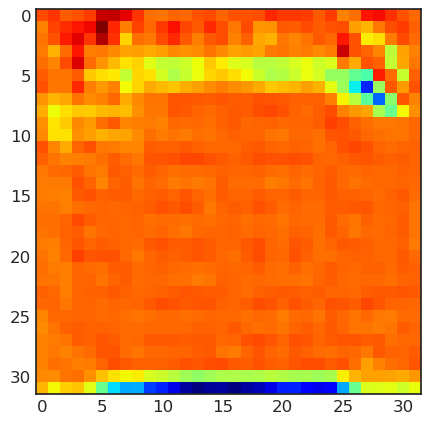

In [48]:
tmp = obj[0][:, :, 0]
plt.imshow(tf.math.angle(tmp), cmap = 'jet')
tf.math.angle(tmp).numpy().mean()

In [60]:
%timeit model.diffraction_to_obj.predict([X_test])

129/129 [==============================] - 1s 5ms/step
802 ms ± 4.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
# %timeit autoencoder.predict([X_test])

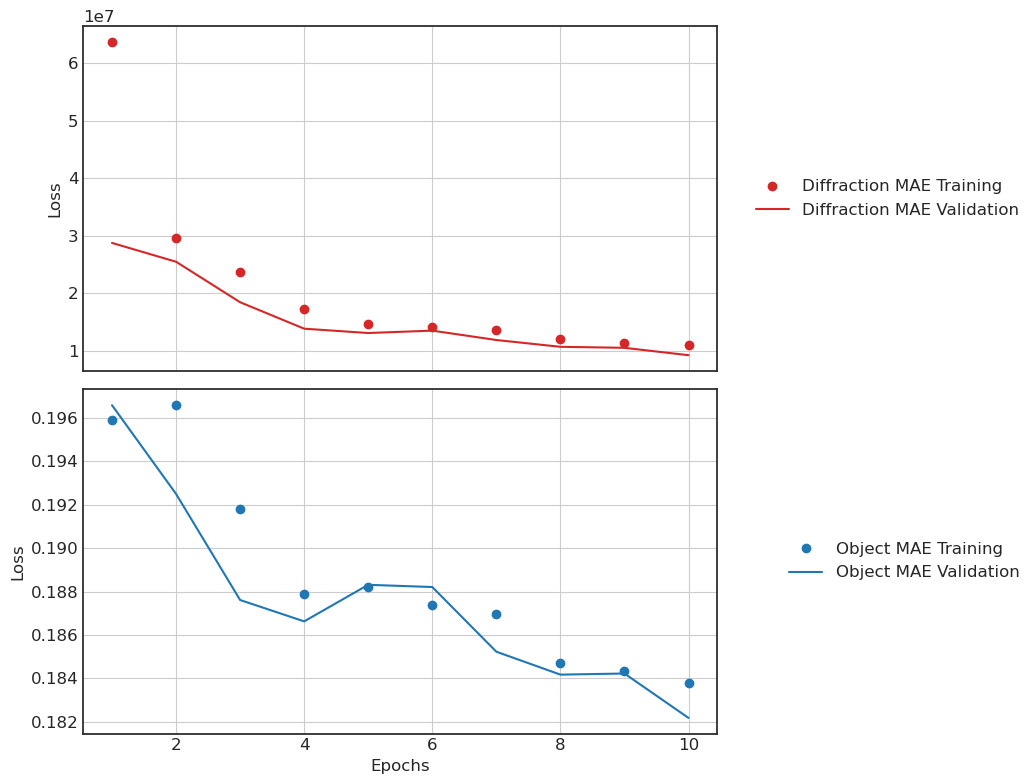

In [38]:
from ptycho import evaluation
reload(evaluation)

evaluation.plt_metrics(history, metric2 = 'trimmed_obj_loss')

In [35]:
history.history.keys()

dict_keys(['loss', 'trimmed_obj_loss', 'pred_diff_channels_loss', 'distribution_lambda_loss', 'pred_diff_channels_1_loss', 'val_loss', 'val_trimmed_obj_loss', 'val_pred_diff_channels_loss', 'val_distribution_lambda_loss', 'val_pred_diff_channels_1_loss', 'lr'])

In [38]:
reload(evaluation)

<module 'ptycho.evaluation' from '/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py'>

phase min: -0.08900445 phase max: 0.07648566


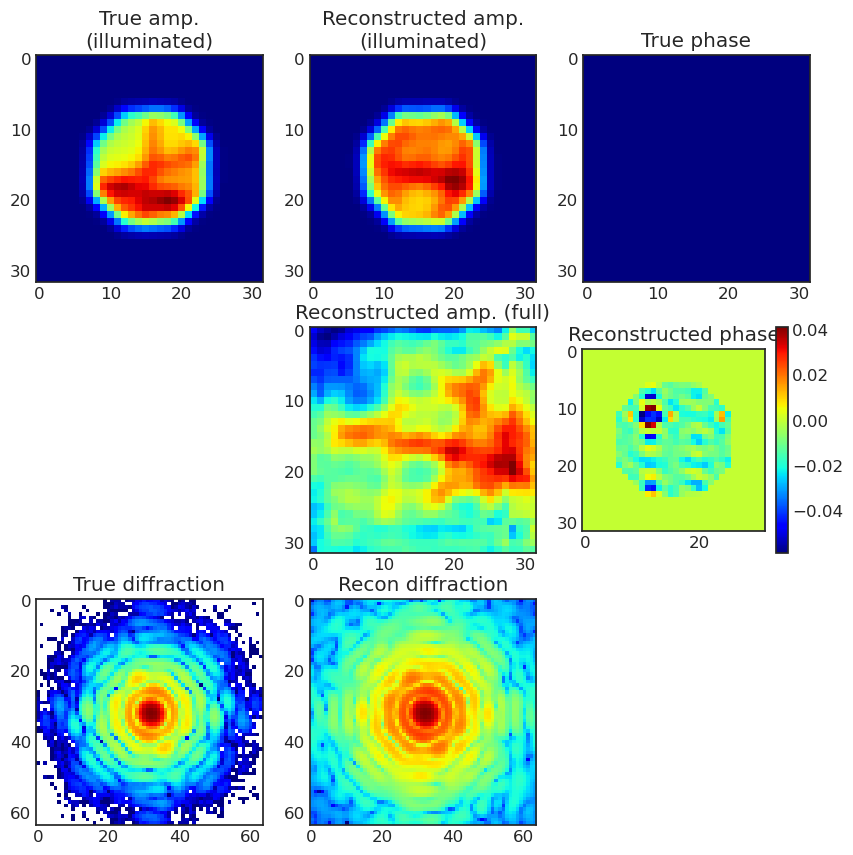

In [41]:
#plt_metrics()
evaluation.summarize(0, a, b, X_test, Y_I_test, Y_phi_test, probe, 0)

In [34]:
reload(evaluation)

<module 'ptycho.evaluation' from '/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py'>

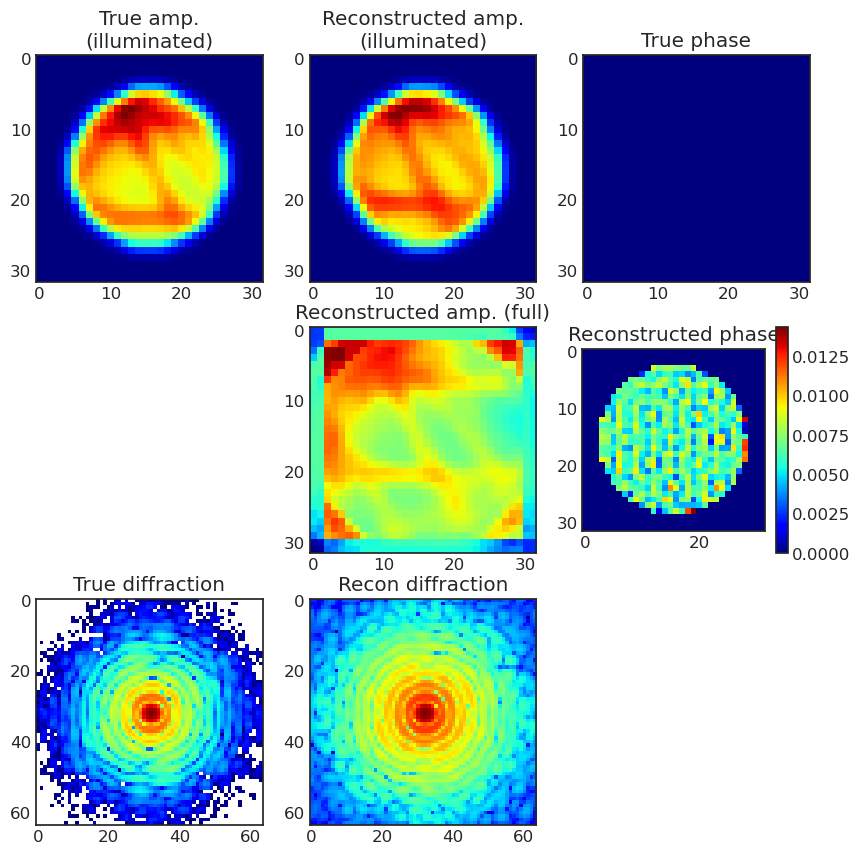

In [35]:
evaluation.summarize(10, a, b, X_test, Y_I_test, Y_phi_test, probe, 0)

/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:51: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i, :, :, channel], cmap = 'jet')


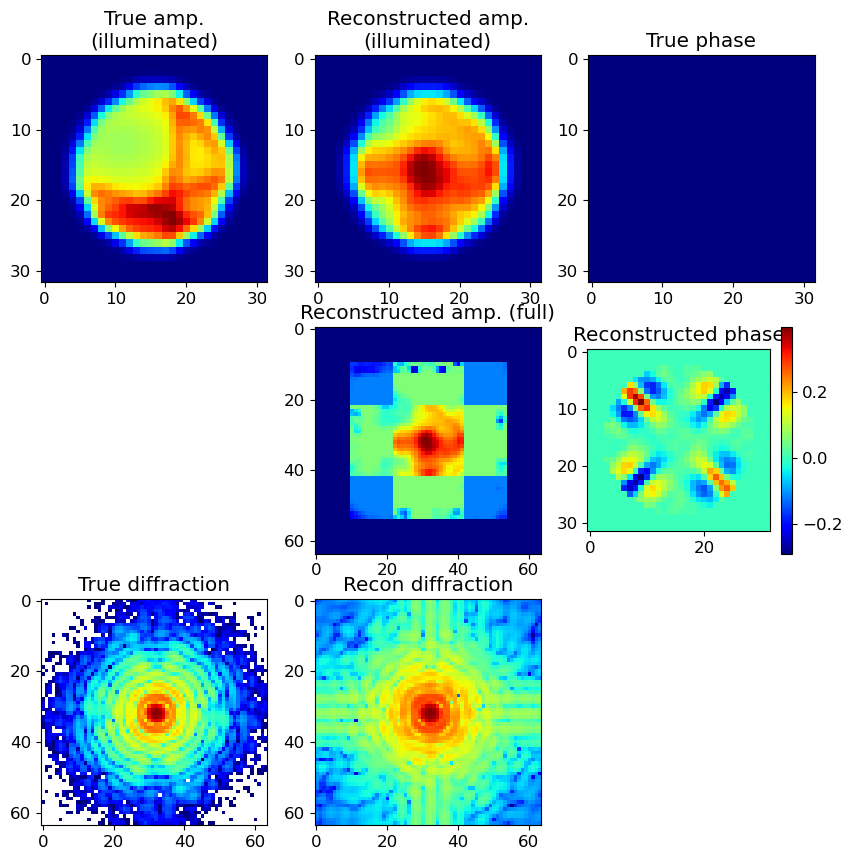

In [30]:
#plt_metrics()
evaluation.summarize(0, a, b, X_test, Y_I_test, Y_phi_test, probe, 0)

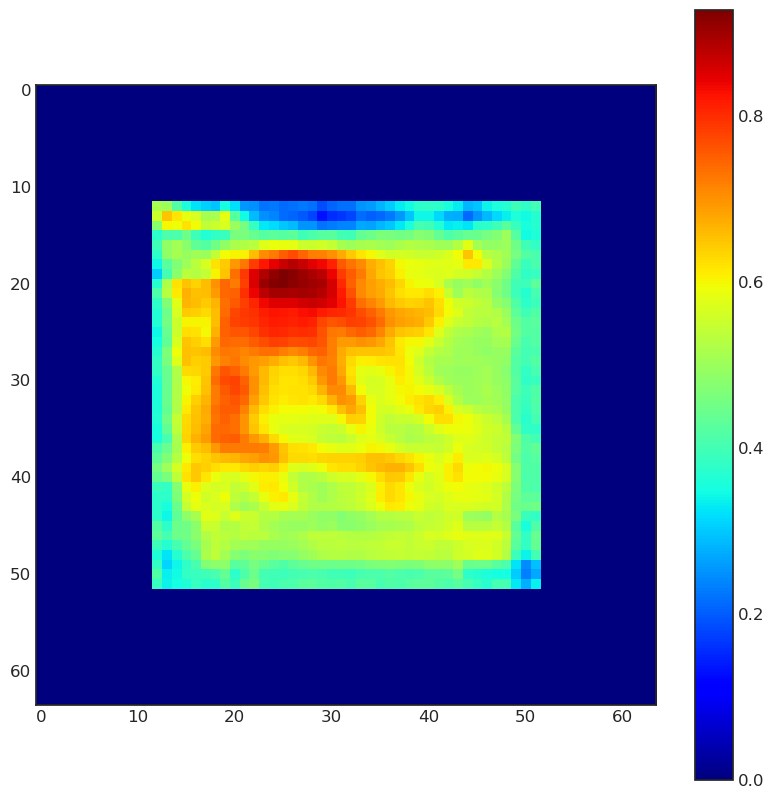

In [47]:
plt.imshow(np.absolute(b[10, :, :, 0]), cmap = 'jet')
plt.colorbar()

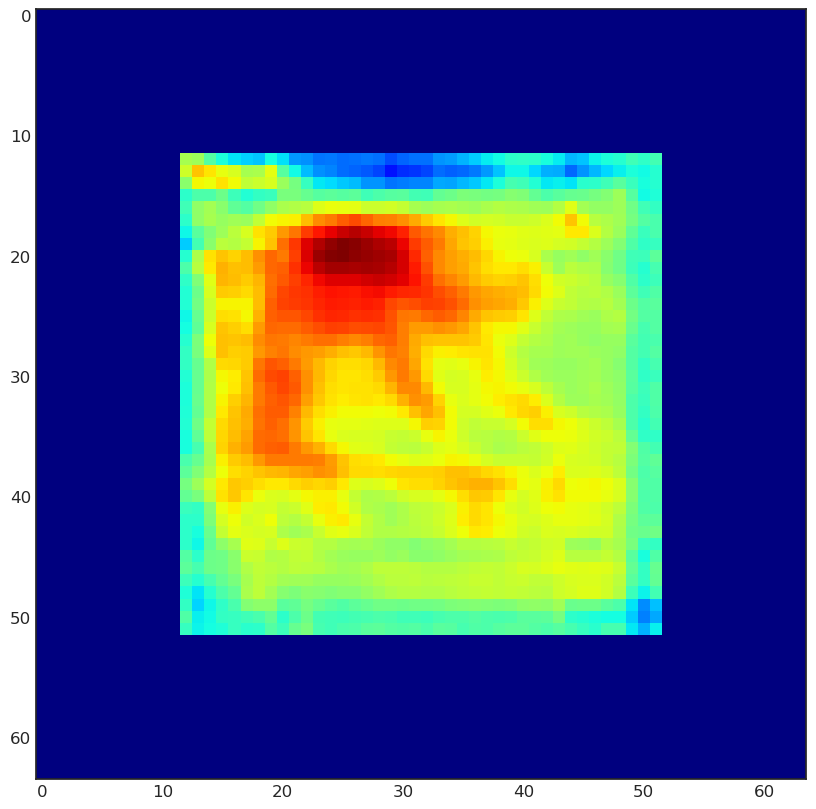

In [46]:
plt.imshow(np.absolute(b[10, :, :, 0]), cmap = 'jet')

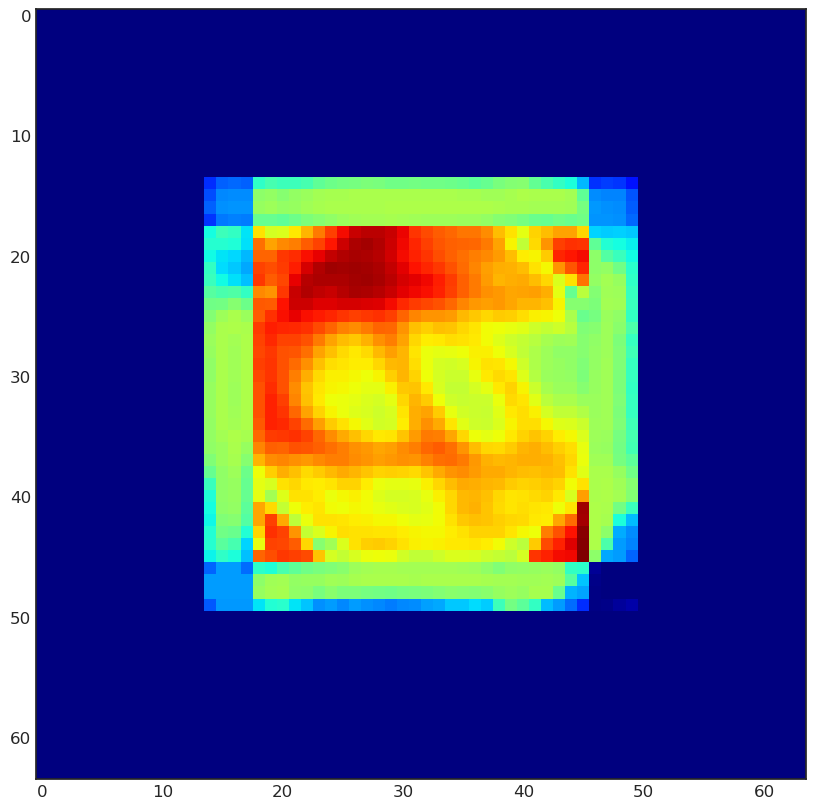

In [35]:
plt.imshow(np.absolute(b[10, :, :, 0]), cmap = 'jet')

In [29]:
b.shape

(4107, 64, 64, 4)

## Evaluate resolution

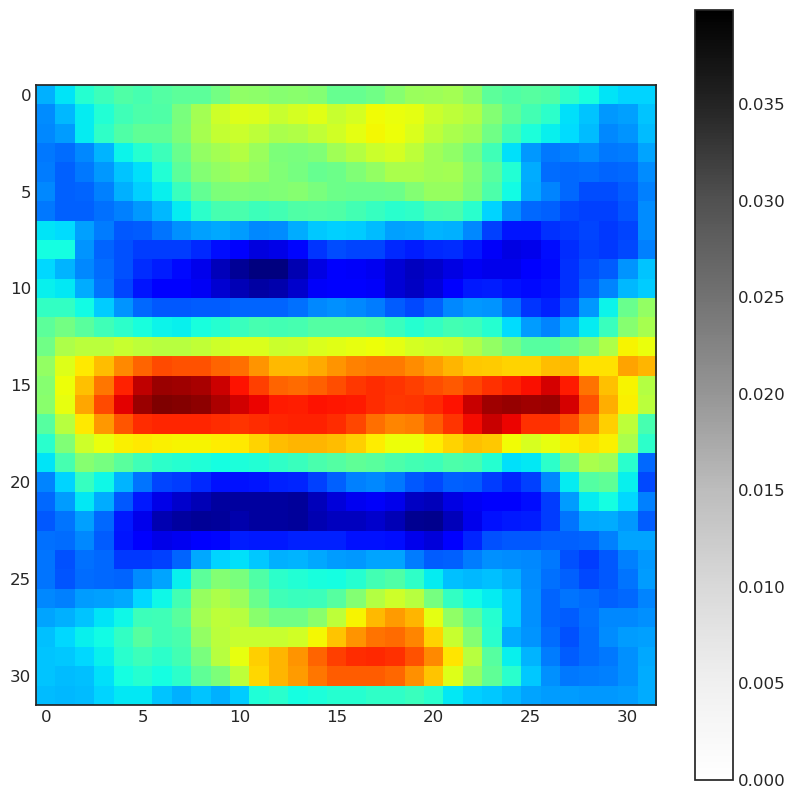

In [39]:
np.random.seed(2)
Y_I_2, Y_phi_2, _Y_I_full_2, _ = datasets.simulate_objects(3, size)

line = np.zeros_like(Y_I_2)
line[:, 31, :, :] = .1
line = f.gf(line, (0, 1, 1, 0))


X_2, Y_I_2, Y_phi_2, _ =\
    physics.illuminate_and_diffract(Y_I_2 + line, Y_phi_2, probe, intensity_scale = intensity_scale)

plt.imshow((Y_I_2 - Y_I_test)[0, :, :, 0])
plt.colorbar()

b2 = model.diffraction_to_obj([X_2])
difference = np.real(b2 - model.diffraction_to_obj([X_test])).mean(axis = 0)

plt.imshow(difference, cmap = 'jet')

lineout_orig = line[0, :, :, 0].sum(axis = 1)
lineout_recon = difference[:, :, 0].sum(axis = 1)

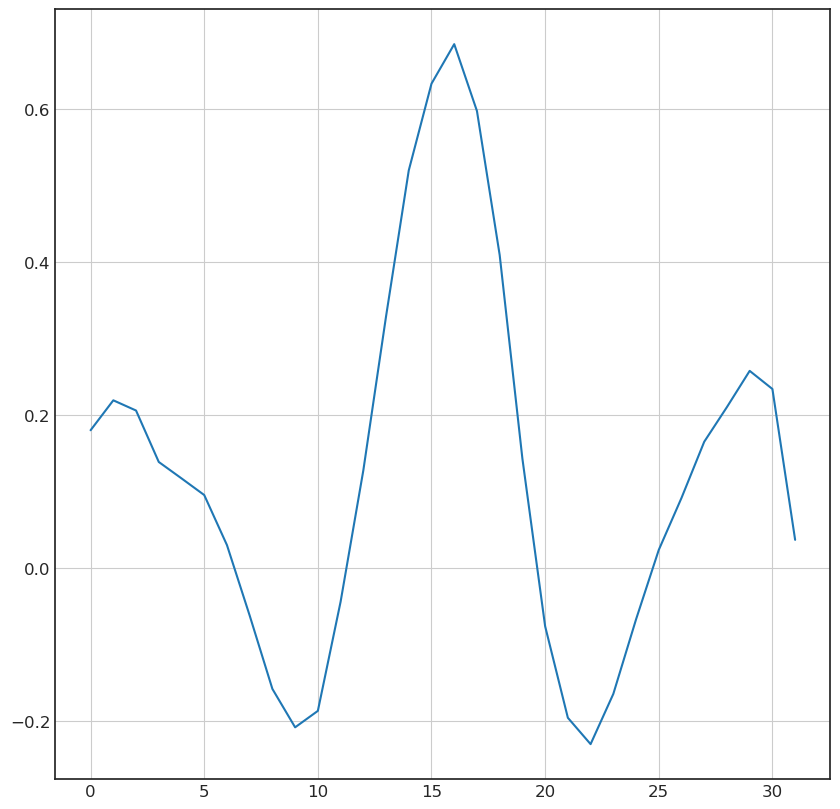

In [41]:
%matplotlib inline
#plt.plot(lineout_orig)
plt.plot(lineout_recon)
plt.grid()

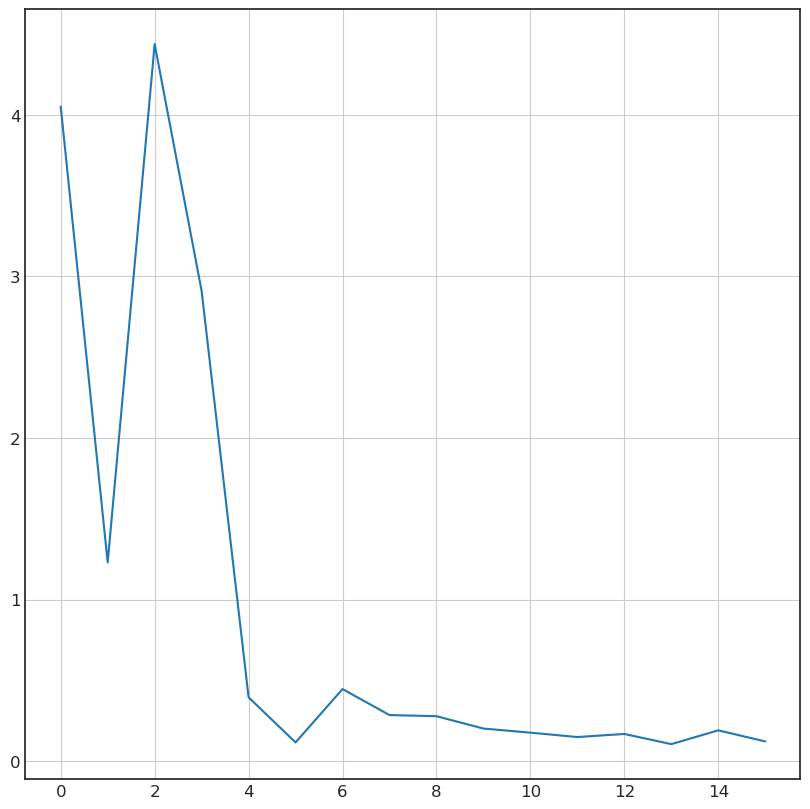

In [44]:
plt.plot(np.abs(f.fftshift(f.fft(lineout_recon)))[16:])
# plt.plot(np.abs(f.fftshift(f.fft(lineout_orig)))[32:])
plt.grid()

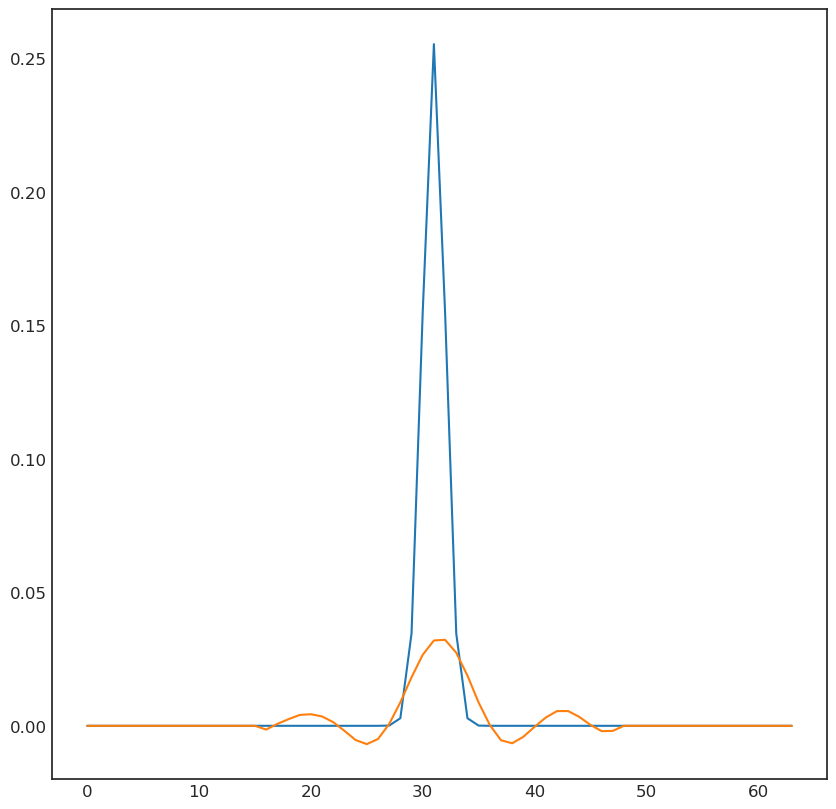

In [205]:
lineout_orig = line[0, :, :, 0].sum(axis = 1)

lineout_recon = difference[:, :, 0].sum(axis = 1)

plt.plot(lineout_orig)
plt.plot(lineout_recon)

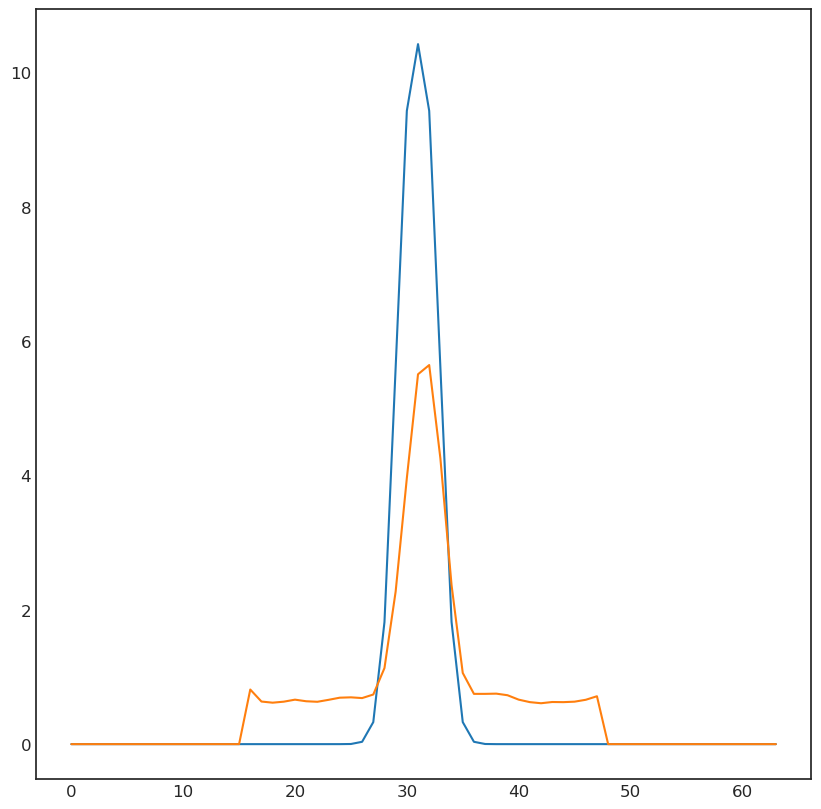

In [97]:
lineout_orig = line[0, :, :, 0].sum(axis = 1)

lineout_recon = difference[:, :, 0].sum(axis = 1)

plt.plot(lineout_orig)
plt.plot(lineout_recon)

In [42]:
from ptycho import baselines as bl
from ptycho.params import params

In [43]:
bigoffset = params()['bigoffset']

bordersize = N // 2 - bigoffset // 4
clipsize = (bordersize + ((gridsize - 1) * offset) // 2)

def stitch(b, norm_Y_I_test = 1, nsegments = big_gridsize * 2 - 1):
    img_recon = np.reshape((norm_Y_I_test * np.absolute(b)), (-1, nsegments,
                                                              nsegments, 64, 64, 1))
    img_recon = img_recon[:, :, :, bordersize: -bordersize, bordersize: -bordersize, :]
    tmp = img_recon.transpose(0, 1, 3, 2, 4, 5)
    stitched = tmp.reshape(-1, np.prod(tmp.shape[1:3]), np.prod(tmp.shape[1:3]), 1)
    return stitched

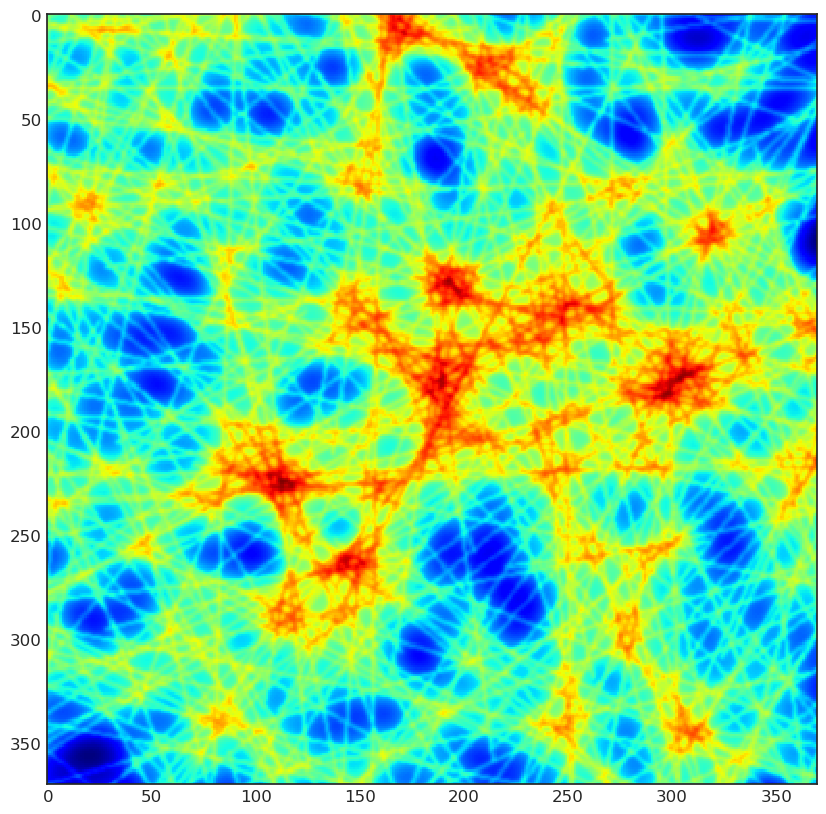

In [44]:
bordersize = N // 2 - bigoffset // 4
clipsize = (bordersize + ((gridsize - 1) * offset) // 2)

plt.imshow(_Y_I_test_full[0, clipsize: -clipsize, clipsize: -clipsize], interpolation = 'none',
          cmap = 'jet')
vmin = np.min(_Y_I_test_full[0, clipsize: -clipsize, clipsize: -clipsize])
vmax = np.max(_Y_I_test_full[0, clipsize: -clipsize, clipsize: -clipsize])

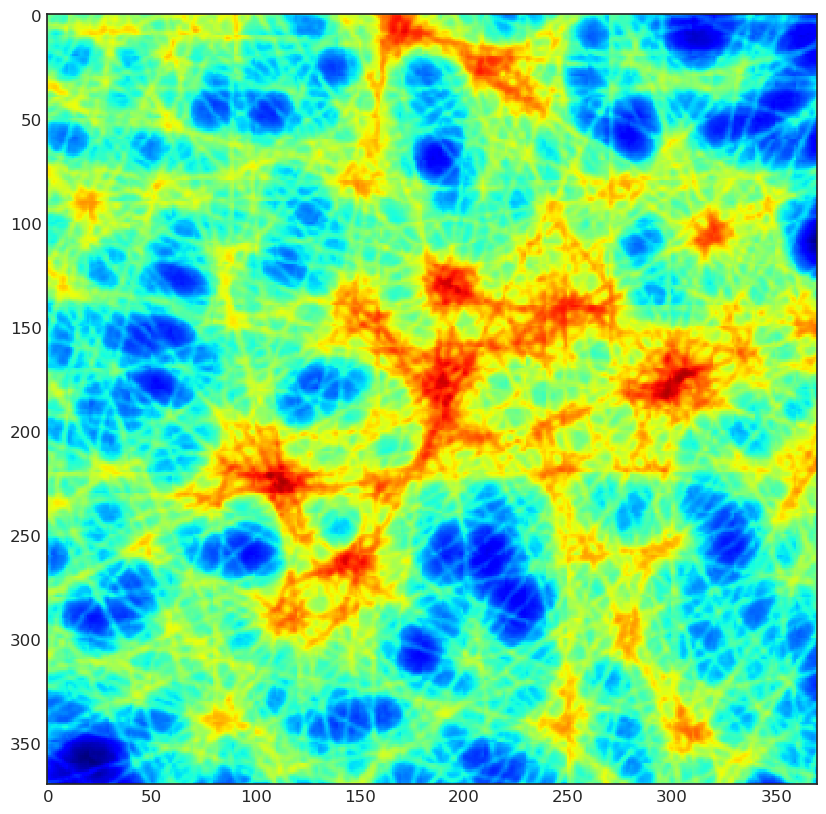

In [45]:
plt.rcParams["figure.figsize"] = (10, 10)

stitched = stitch(b, norm_Y_I_test, nsegments=37)

plt.imshow(stitched[0], interpolation = 'none', vmin = vmin, vmax = vmax, cmap = 'jet')

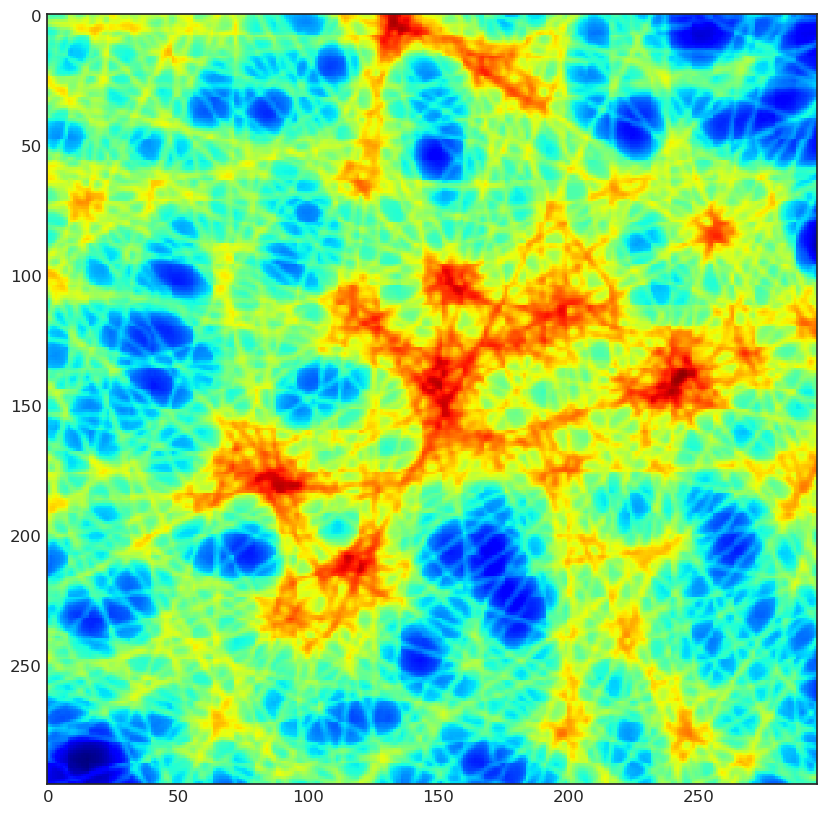

In [39]:
plt.rcParams["figure.figsize"] = (10, 10)

stitched = stitch(b, norm_Y_I_test, nsegments=37)

plt.imshow(stitched[0], interpolation = 'none', vmin = vmin, vmax = vmax, cmap = 'jet')

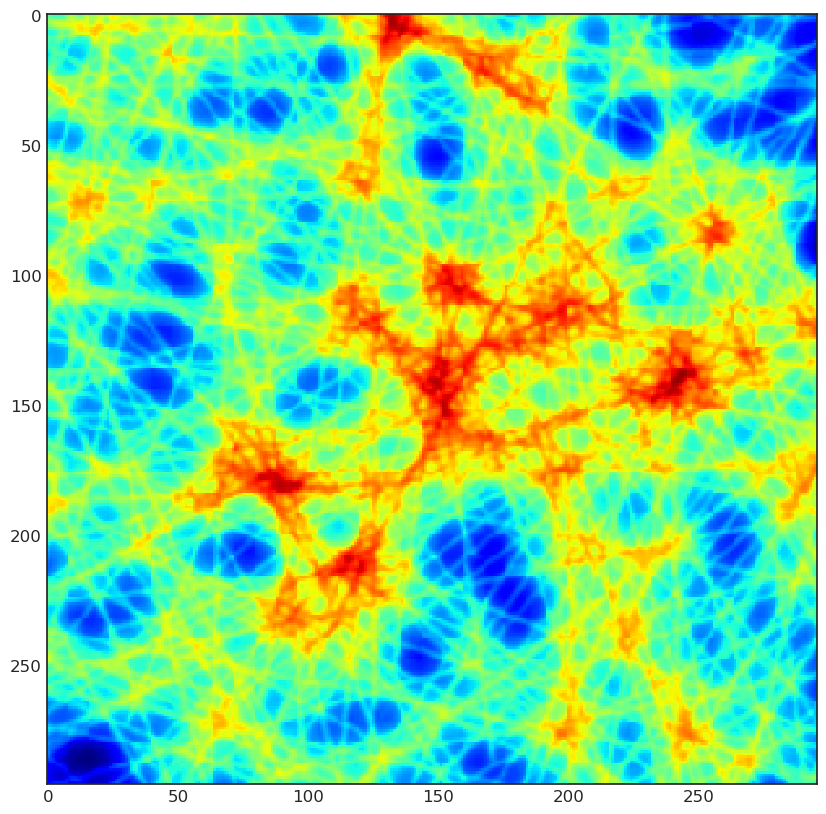

In [38]:
plt.rcParams["figure.figsize"] = (10, 10)

stitched = stitch(b, norm_Y_I_test, nsegments=37)

plt.imshow(stitched[0], interpolation = 'none', vmin = vmin, vmax = vmax, cmap = 'jet')

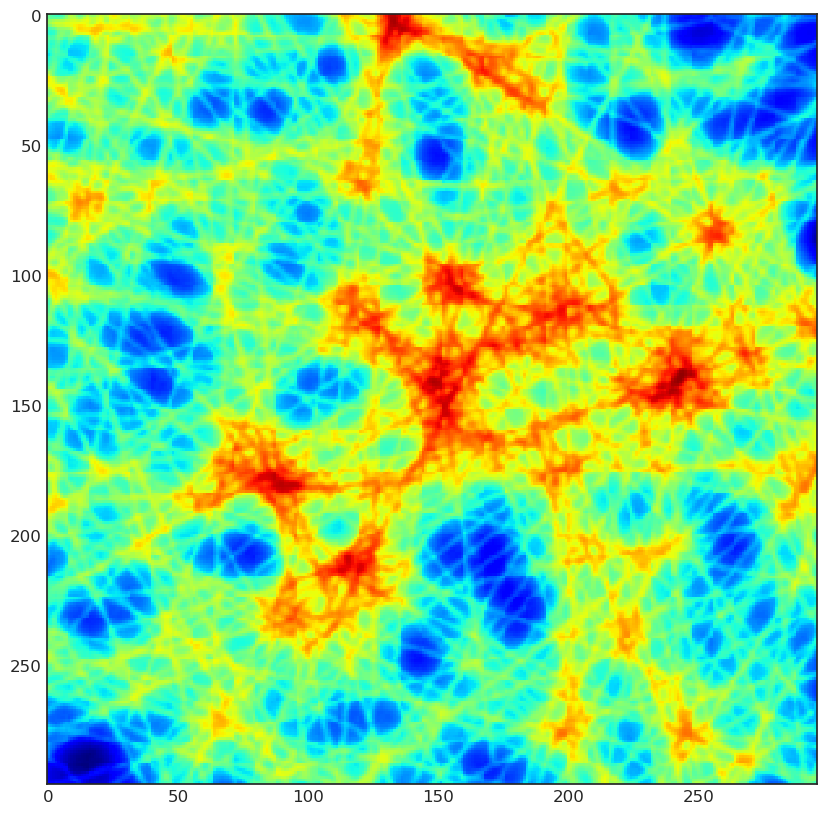

In [36]:
plt.rcParams["figure.figsize"] = (10, 10)

stitched = stitch(b, norm_Y_I_test, nsegments=37)

plt.imshow(stitched[0], interpolation = 'none', vmin = vmin, vmax = vmax, cmap = 'jet')

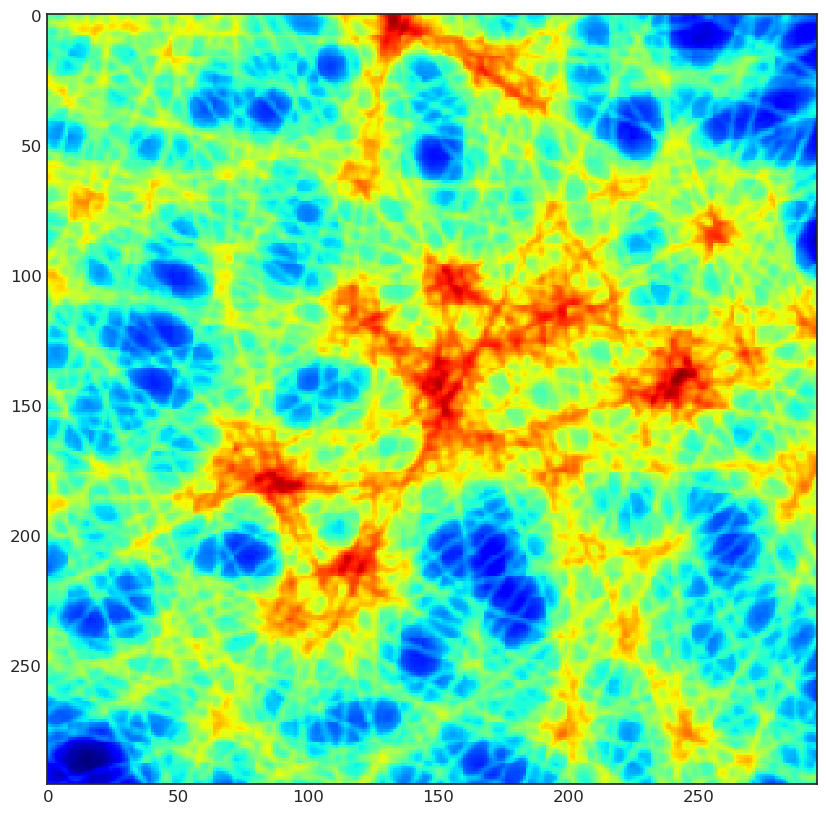

In [42]:
plt.rcParams["figure.figsize"] = (10, 10)

stitched = stitch(b, norm_Y_I_test, nsegments=37)

plt.imshow(stitched[0], interpolation = 'none', vmin = vmin, vmax = vmax, cmap = 'jet')

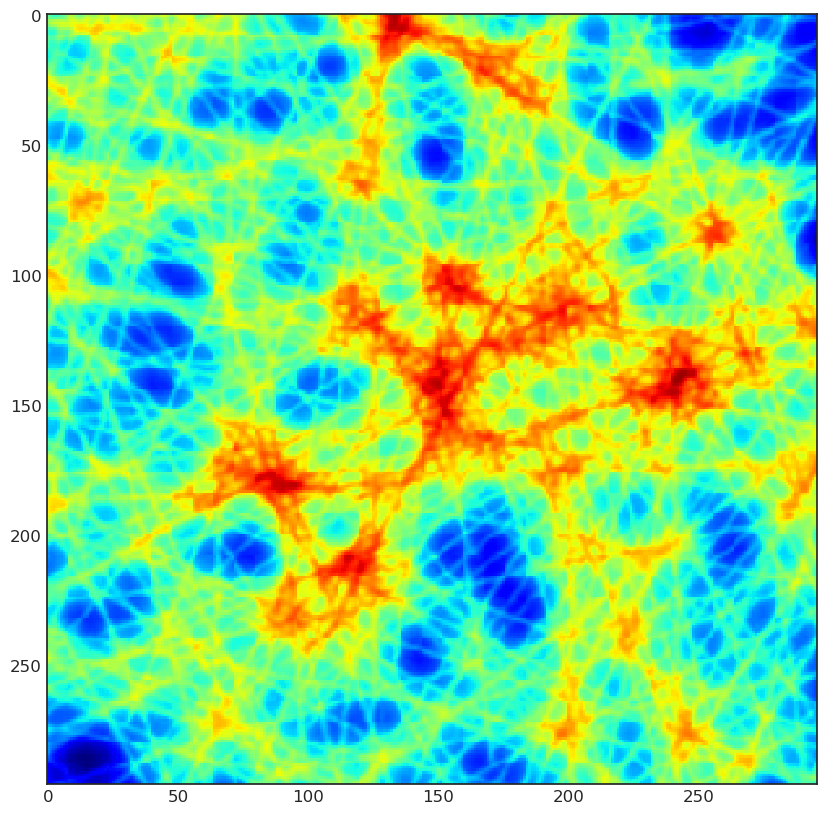

In [30]:
plt.rcParams["figure.figsize"] = (10, 10)

stitched = stitch(b, norm_Y_I_test, nsegments=37)

plt.imshow(stitched[0], interpolation = 'none', vmin = vmin, vmax = vmax, cmap = 'jet')

In [34]:
bl.nepochs = 20

In [35]:
baseline_model = bl.train((X_train[:, :, :, :1]), Y_I_train[:, :, :, :1], Y_phi_train[:, :, :, :1])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

Epoch 8/20
366/366 [==============================] - 5s 13ms/step - loss: 0.0058 - conv2d_12_loss: 0.0058 - conv2d_19_loss: 4.7005e-05 - val_loss: 0.0060 - val_conv2d_12_loss: 0.0059 - val_conv2d_19_loss: 5.7063e-05 - lr: 5.0000e-04
Epoch 9/20
366/366 [==============================] - 5s 13ms/step - loss: 0.0058 - conv2d_12_loss: 0.0058 - conv2d_19_loss: 4.7237e-05 - val_loss: 0.0057 - val_conv2d_12_loss: 0.0057 - val_conv2d_19_loss: 1.0451e-05 - lr: 5.0000e-04
Epoch 10/20
366/366 [==============================] - 5s 13ms/step - loss: 0.0058 - conv2d_12_loss: 0.0058 - conv2d_19_loss: 4.7158e-05 - val_loss: 0.0059 - val_conv2d_12_loss: 0.0058 - val_conv2d_19_loss: 1.1731e-04 - lr: 5.0000e-04
Epoch 11/20
366/366 [==============================] - ETA: 0s - loss: 0.0058 - conv2d_12_loss: 0.0058 - conv2d_19_loss: 4.7479e-05
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
366/366 [==============================] - 5s 12ms/step - loss: 0.0058 - conv2d_12_loss:

129/129 [==============================] - 1s 4ms/step


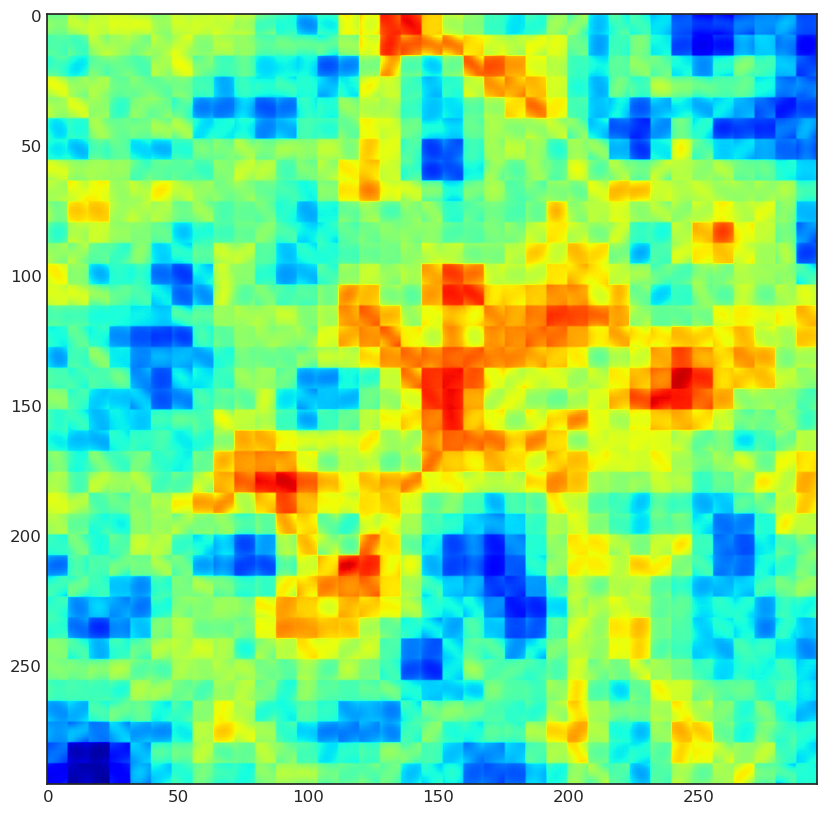

In [36]:
baseline_pred_I, baseline_pred_phi = baseline_model.predict([X_test[:, :, :, 0]])
baseline_stitched = stitch(baseline_pred_I, norm_Y_I_test, nsegments=37)

plt.imshow(baseline_stitched[0], cmap = 'jet', vmin = vmin, vmax = vmax)

In [47]:
# gt = _Y_I_test_full[:, clipsize: -clipsize, clipsize: -clipsize]
# tf.keras.losses.MeanAbsoluteError()(gt, stitched)

In [48]:
# tf.keras.losses.MeanSquaredError()(gt, stitched)

In [49]:
# tf.keras.losses.MeanAbsoluteError()(gt, baseline_stitched)

In [88]:
# tf.keras.losses.MeanSquaredError()(gt, baseline_stitched)

<tf.Tensor: shape=(), dtype=float32, numpy=0.00013008271>

In [50]:
baseline_model.evaluate([X_test[:, :, :, 0]])

129/129 [==============================] - 0s 641us/step - loss: 0.0000e+00 - conv2d_12_loss: 0.0000e+00 - conv2d_19_loss: 0.0000e+00


[0.0, 0.0, 0.0]

In [51]:
i = 0
# consistency check: should be close to equal
np.sum(tf.math.abs(a[i])**2), np.sum(tf.math.abs(X_test[i])**2),\
np.sum(tf.math.abs(a)**2), np.sum(tf.math.abs(X_test)**2)

(1187.3422, 1185.133, 4194472.5, 4196112.0)

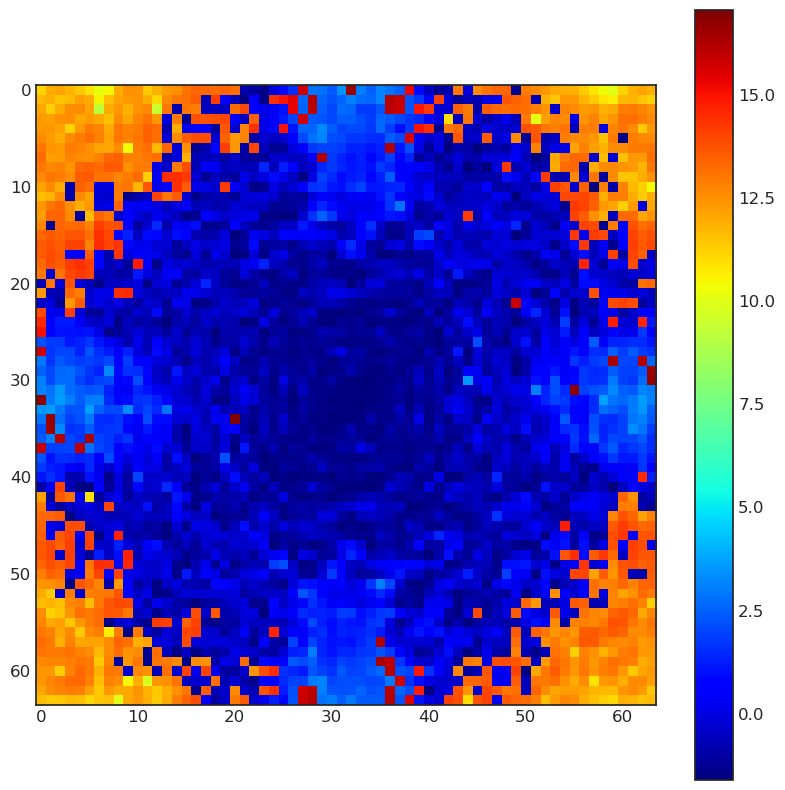

In [52]:
plt.imshow(np.log(.2 + np.abs((a[i, :, :, 0] - X_test[i, :, :, 0]) / (X_test[i, :, :, 0] + 1e-9))), cmap ='jet')
plt.colorbar()

In [39]:
# !ln ../xrd_clustering/notebooks/visualization.py
from ptycho import visualization as vis
reload(vis)

<module 'ptycho.visualization' from '/home/ollie/Documents/scratch/ptycho/ptycho/visualization.py'>

diffraction reconstruction


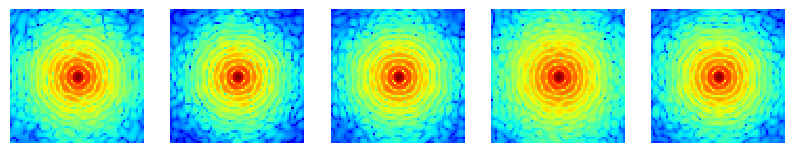

diffraction ground truth


/tmp/ipykernel_682357/1178352548.py:10: RuntimeWarning: divide by zero encountered in log
  vis.display_imgs(np.log(np.absolute(X_test[:, :, :, 0]))[i:i + off])


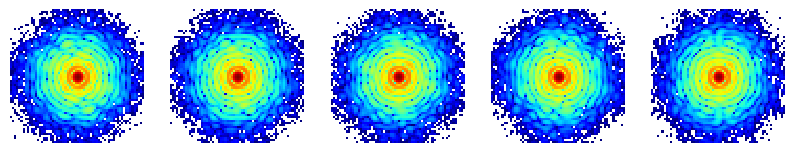

object reconstruction (amp)


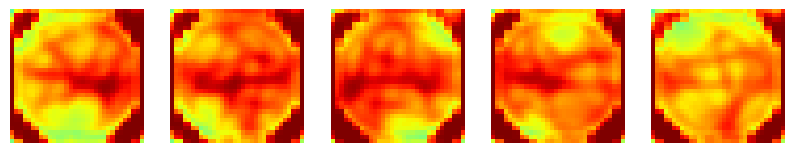

object ground truth


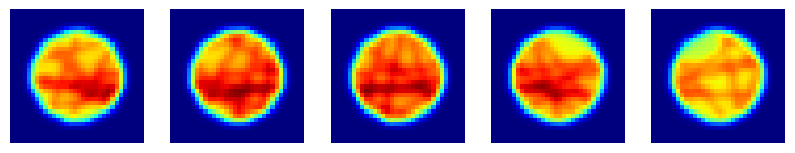

In [40]:
off = 5

vmin = np.min(Y_I_test[:, 16:-16, 16:-16][i:i + off])
vmax = np.max(Y_I_test[:, 16:-16, 16:-16][i:i + off])

print('diffraction reconstruction')
vis.display_imgs(np.log(np.absolute(a[:, :, :, 0]))[i:i + off])

print('diffraction ground truth')
vis.display_imgs(np.log(np.absolute(X_test[:, :, :, 0]))[i:i + off])

print('object reconstruction (amp)')
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16, 0])[i:i + off], vmin = vmin, vmax = vmax)
# print('object reconstruction (phase)')
# vis.display_imgs(np.angle(b[:, 16:-16, 16:-16, 0])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth')
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16, 0][i:i + off], vmin = vmin, vmax = vmax)

## save model

In [249]:
history.history.keys()

dict_keys(['loss', 'pred_amplitude_loss', 'padded_obj_loss', 'pred_amplitude_1_loss', 'val_loss', 'val_pred_amplitude_loss', 'val_padded_obj_loss', 'val_pred_amplitude_1_loss', 'lr'])

In [250]:
np.save(path+'str_history', history.history)

In [251]:
# model.load_weights(checkpoint_filepath)

In [68]:
# val_losses=hist.history['val_loss']
# min_epoch=np.argmin(val_losses)+1
# print (min_epoch)
# np.save(path+'%s/min_epoch' %(wt_path), min_epoch)
autoencoder.save('{}.h5'.format(wt_path))